In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50527, # vocab size
    "context_length": 1024, # context length
    "emb_dim": 768, # Embedding dimension,
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # Using a placeholder transformer block that will be defined and uses later
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        ) 
        # Using a placehold for the LayerNorm that will be implemented and used later
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        
class DummyTransformerBlock(nn.Module):
    # Dummy transformer block that will be replaced by a real one later
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x # does nothing but return the input
    
class DummyLayerNorm(nn.Module):
    # Simple placeholder to be replaced by LayerNorm
    def __init__(self, normalized_shape, eps=1e-5): # paramters for the layernorm interface.
        super().__init__()    

    def forward(self, x):
        return x # Does nothing but return the input

# An Example

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


- Now we initialize 124M parameter dummy gpt model and feed it the tokenzied batch

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50527])
tensor([[[-0.4811,  0.4325, -0.6385,  ..., -0.9398, -0.1178,  0.1945],
         [-0.0843,  0.4519,  0.2060,  ..., -0.5766, -0.5318, -1.4576],
         [ 0.7199,  0.0575,  0.2597,  ..., -1.0028, -1.9158, -0.5157],
         [ 1.8422,  0.0252,  0.9573,  ..., -0.0315, -0.2424, -0.2487]],

        [[-0.9559,  1.3580, -0.4468,  ..., -0.5588,  0.4615, -0.3940],
         [-0.5088,  0.2881,  0.5815,  ..., -0.0353,  0.1133, -0.5654],
         [ 0.0683, -1.4644,  1.1000,  ..., -1.2006, -0.6936, -0.2516],
         [ 0.6819, -0.8203,  1.2607,  ...,  1.1441, -0.7271, -2.8555]]],
       grad_fn=<UnsafeViewBackward0>)


# Implement LayerNorm


In [6]:
# Example
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- The above neural network has one Linear Layer followed by Relu.

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean: {mean}")
print(f"Variance: {var}")
print(mean.shape, var.shape)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
torch.Size([2, 1]) torch.Size([2, 1])


- The first row is the mean/variance value for the first row, and the second row is the mean/variance value for the second row.
- `keep_dims=True` ensure that the output tensor has the same number of dimensions as the input tensor, although the operation reduces the tensor along the specified dimension.
- Check below when the `keep_dims=False`

In [8]:
print(out.mean(dim=-1))
print(out.mean(dim=-1).shape)

tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
torch.Size([2])


In [9]:
out_norm = (out - mean)/ torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print(f"Normalized output : {out_norm}")
print(f"Mean: {mean}")
print(f"Variance: {var}")

Normalized output : tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
# Coding the LayerNorm Class


In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


- Variable `eps` is a very small number added to prevent division by zero.
- `scale` and `shift` are 2 trainable parameters (same dimension as input). This is in case during training it is determined that doing so would improve the model's performance on its training task. So the model will learn scaling and shifting.

In [12]:
# lets apply it to the batch data
ln = LayerNorm(emb_dim=5)
out_ln =  ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print(f"Mean: {mean}")
print(f"Variance: {var}")

Mean: tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU
- GELU activation is used in GPT rather than RELU
- While Relu is the most commonly one that has been used to train Neural Networks, there are 2 alternatives, GELU and SWIGLU.
- These 2 functions are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively. They give improved performance for training compared to RELU.

The GELU activation function is defined as:

$$ \text{GELU}(x) = x \cdot \Phi(x) $$

where \( \Phi(x) \) is the Cumulative Distribution Function (CDF) of the standard normal distribution.

An approximation of GELU is:

$$ \text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right)\right) $$

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1+ torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

# HOW DOES THE GELU COMPARE TO RELU
- Note that Relu is a piecewise Linear. The output is same as input when input is positive, otherwise its zero.
- Gelu is a smooth non-linear function that approximates Relu. It has a non-zero gradient for almost all negative values (expect approx at x = -0.75)

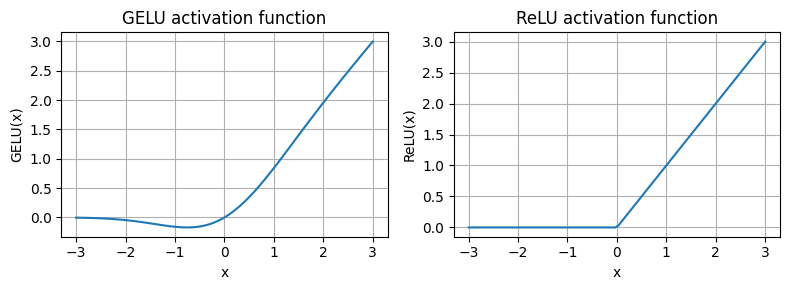

In [14]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

# FEED FORWARD WITH GELU

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Adding shortcut connections:

In [17]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        num_layers = len(layer_sizes)
        
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(n, m), GELU()) for n, m in zip(layer_sizes[0:-1], layer_sizes[1:])
            ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape==layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

# Examples

In [26]:
layer_sizes = [3]*3 + [1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shourcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes, use_shortcut=False
)

In [27]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [28]:
print_gradients(model_without_shourcut, sample_input)
# We can observe the problem of vanishing gradient problem.

layers.0.0.weight has gradient mean of 0.005863716825842857
layers.1.0.weight has gradient mean of 0.0074560800567269325
layers.2.0.weight has gradient mean of 0.05755717679858208


In [29]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)
# Gradients stalibilize and does not vanish

layers.0.0.weight has gradient mean of 0.023120101541280746
layers.1.0.weight has gradient mean of 0.019320642575621605
layers.2.0.weight has gradient mean of 0.21998417377471924


- Now we have all the blocks we need to build GPT architecture.

# Implementation of Transformer Block

In [32]:
from utils import MultiHeadAttention

In [33]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x # assign `x` to shortcut to use for future steps
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x # assign `new x` to shortcut to use for future steps
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
        

- The above code defines a Transformer block in pytorch.
- It includes multihead attention and feed-forward.
- All is configured using a configuration dictionary.
- LayerNorm is applied between these 2 components and dropout is applied after them to prevent overfitting. This is also called `PreLayerNorm`.
- Original transformer had layer normalization after the self-attention and feed-forward. That was `PostLayerNorm`. But very often leads to worse training dynamics.
- Each component is followed by a shortcut connection that adds the input to the output.

In [34]:
# INSTANTIATE A TRANSFORMER BLOCK

In [35]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(cfg=GPT_CONFIG_124M)
output = block(x)

In [36]:
print(f"Input Shape: {x.shape}")
print(f"Output Shape: {output.shape}")

Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])


# THE GPT MODEL
- **Below is the code of the Dummy GPT model we have implemented at the start**
```python
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # Using a placeholder transformer block that will be defined and uses later
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        ) 
        # Using a placehold for the LayerNorm that will be implemented and used later
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        
class DummyTransformerBlock(nn.Module):
    # Dummy transformer block that will be replaced by a real one later
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x # does nothing but return the input
    
class DummyLayerNorm(nn.Module):
    # Simple placeholder to be replaced by LayerNorm
    def __init__(self, normalized_shape, eps=1e-5): # paramters for the layernorm interface.
        super().__init__()    

    def forward(self, x):
        return x # Does nothing but return the input
```

In [37]:
# FINAL CLASS
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# Example 

In [28]:
# import tiktoken

# tokenizer = tiktoken.get_encoding("gpt2")
# batch_j = []
# txt1 = "Every effort moves you"
# txt2 = "Every day holds a"

# batch_j.append(torch.tensor(tokenizer.encode(txt1)))
# batch_j.append(torch.tensor(tokenizer.encode(txt2)))
# batch_j = torch.stack(batch_j, dim=0)
# batch_j = batch_j.to(device)
# print(batch_j)
# print(batch_j.device)
# print(type(batch_j))


In [38]:
%%time
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print(f"Input Shape:\n {batch}")
print(f"Output shape: {out.shape}")
print(out)

Input Shape:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50527])
tensor([[[-0.4080,  1.2829,  0.1245,  ..., -0.1089,  0.3501,  1.3657],
         [-0.2078,  0.2583,  0.5438,  ..., -0.2828, -0.6319,  0.0631],
         [-0.9061, -0.0543, -0.3181,  ..., -0.5065, -0.7807,  0.1212],
         [-0.0197,  0.0990, -0.2749,  ..., -0.2600, -0.7665,  0.1369]],

        [[-0.8632,  1.1687, -0.1051,  ..., -0.1885,  0.2798,  1.1261],
         [-0.0049,  1.0500, -0.4110,  ..., -0.4031, -0.4179,  0.8799],
         [-0.6369,  0.0834,  0.1579,  ..., -0.1133,  0.3734,  0.4102],
         [ 0.4262,  0.4200, -0.5230,  ...,  0.4228, -0.3449,  0.5113]]],
       grad_fn=<UnsafeViewBackward0>)
CPU times: user 2.42 s, sys: 179 ms, total: 2.6 s
Wall time: 708 ms


In [30]:
# Number of Model Parameters:

In [39]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163424256


- The reason the number is larger than 124M is b/c of a concept called _weight typing_.
- Meaning the **original** GPT-2 architecture reuses the weights from the token embedding layer in it output layer.
- Let see the shape of the token embedding layer and the linear output layer.

In [40]:
print(f"Token embedding layer shape: {model.tok_emb.weight.shape}")
print(f"Linear output layer shape: {model.tok_emb.weight.shape}")

Token embedding layer shape: torch.Size([50527, 768])
Linear output layer shape: torch.Size([50527, 768])


In [41]:
# So if we remove the output layer parameters count (since that weight matrix is the same as the token embedding matrix)
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Number of trainable parameters considering tying weights : {total_params_gpt2}")

Number of trainable parameters considering tying weights : 124619520


- NOTE: The author's experience is that using separate token embedding and output layers results in better training and model performance; hence, he suggests to use separate layers in the GPTModel implementation in the book.
- So the model that we have implemented has `164M` parameters

# Number of parameters in the feed forward and attention modules

In [42]:
total_size_bytes = total_params * 4 # This is assuming float32, 4 bytes per parameter
total_size_mb = total_size_bytes/(1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 623.41 MB


# Function for GPT to generate the next text

In [43]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    To generate the next text one token at a time. Crop the context if the input 
    is longer than context length.
    idx is (batch, n_tokens)
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # pick the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # Take only the last time step as this is the next token
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=-1) # add the newly generated token to the original input

    return idx

In [44]:
# example
start_context = "Hello I am"
encoded = tokenizer.encode(start_context)
print(f"Encoded : {encoded}")
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Unsqueeze adds the batch dimension
print(f"Encoded tensor shape: {encoded_tensor.shape}")

Encoded : [15496, 314, 716]
Encoded tensor shape: torch.Size([1, 3])


In [45]:
# set the model to `eval` so that random components like dropout, that are used only during training are disabled.
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)

print(f"Output: {out}")
print(f"Output Length: {len(out[0])}")

Output: tensor([[15496,   314,   716, 30680, 23289,  6704, 18086, 21482, 33623]])
Output Length: 9


In [47]:
# Now we can used decode method of the tokenizer to convert the IDS back to words/tokens
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello I am wineslinuxonymous pitcherwageす


In [ ]:
# The output is gibberish, since the model is not trained.